In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

In [2]:
file_path = './final_ipynb/'

In [3]:
# Retrieve the train and set data
x_train_df, y_train_df = pd.read_csv(file_path+'x_train.csv'), pd.read_csv(file_path+'y_train.csv')
x_test_df, y_test_df = pd.read_csv(file_path+'x_test.csv'), pd.read_csv(file_path+'y_test.csv')

In [4]:
ccw = compute_class_weight(class_weight='balanced', 
                          classes=np.unique(y_train_df.values.flatten()), 
                          y=y_train_df.values.flatten())

weights = np.ones(y_train_df.shape[0], dtype='float')

for i, val in enumerate(y_train_df.values.flatten()):
    weights[i] = ccw[val - 1]

In [22]:
clf = xgb.XGBClassifier(verbosity=2,
                        early_stopping_rounds=5)

In [5]:
clf.fit(x_train_df, y_train_df, 
        sample_weight=weights,
        eval_set=[(x_test_df, y_test_df)])

[17:25:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-logloss:0.45125
[17:25:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-logloss:0.31801
[17:25:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-logloss:0.23200
[17:25:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-logloss:0.17549
[17:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-logloss:0.13612
[17:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-logloss:0.10912
[17:25:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[6]	validat

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [25]:
y_test_pred = clf.predict(x_test_df)

In [26]:
models_benchmark = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score'])

def getMetrics(model_name, y_truth, y_pred):
    # Macro-avg is recommended to keep minority classes relevant
    # Weighted-avg is recommended to keep majority classes relevant
    print(f'Metrics')
    acc = metrics.accuracy_score(y_truth, y_pred)
    rec = metrics.recall_score(y_truth, y_pred, zero_division=0)
    pre = metrics.precision_score(y_truth, y_pred, zero_division=0)
    f1s = metrics.f1_score(y_truth, y_pred, zero_division=0)

    models_benchmark.loc[model_name] = [acc, rec, pre, f1s]
    display(models_benchmark.loc[model_name])
    return

def getCM(model_name, y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    plt.title(f'{model_name}', fontsize=20)

    sns.heatmap(cm_normalized, annot=True, fmt='.3f')

    plt.xticks(rotation=45)
    plt.ylabel('Real outcome', fontsize=16)
    plt.xlabel('Predicted outcome', fontsize=16)
    plt.ioff()
    plt.show()
    return

Metrics


Accuracy     0.987260
Recall       0.982568
Precision    0.951574
F1-score     0.966823
Name: XGBoost, dtype: float64

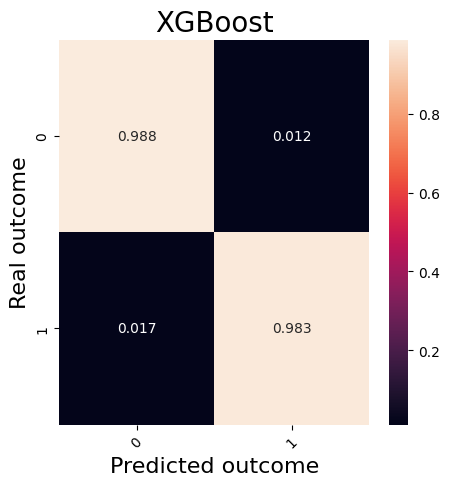

In [27]:
model_name = 'XGBoost'
getMetrics(model_name, y_test_pred, y_test_df.values.flatten())
getCM(model_name, y_test_pred, y_test_df.values.flatten())

In [28]:
clf.save_model('./Models/XGB.json')

In [23]:
clf.load_model('./Models/XGB.json')